Integrating Eric Denovellis' state space decoding (https://elifesciences.org/articles/64505, https://github.com/Eden-Kramer-Lab/replay_trajectory_classification)

Heavily based on pose_analysis repo https://github.com/edeno/pose_analysis for workflow

8/4/2024

Blake Porter

- Starting simple with 1D only, no stats. pose_analysis uses Dask for parallel computing. I dont know how it works but I'll have it here.
- 8/20 Added 2D
- 8/27 realized upsampling on pre-linearized data will fill the upsampled bins with interpolated lin pos data. E.g., rat runs from lin pos 100 to 500,
     it will fill values between 100 500 but the rat was never in those positions.
     Changing so 2D data is first upsampled then that is linearized.
- 9/10 For now, creating a different file to handle the classifier (vs the decoder) since the data output is different enough to make compatiability, esp plotting, hard at his point in development

- 9/16/2024 I HAVE NO IDEA IF THIS WORKS I DONT REMEMBER WHAT STATE IT WAS IN. LAST I RAN IT 2D WAS NOT WORKING BECAUSE I WAS TRYING TO USE THE GLM

In [1]:

import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd
import scipy as sp
import pickle

from replay_trajectory_classification import SortedSpikesDecoder, SortedSpikesClassifier, Environment, RandomWalk

from track_linearization.utils import (
    make_actual_vs_linearized_position_movie,
    make_track_graph,
    plot_graph_as_1D,
    plot_track_graph,
)

from track_linearization import get_linearized_position

import pynapple as nap

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Own modules
from jlab_nwb import JLabNWBHandler
import analyze_one_nwb_settings.import_settings as analyze1_settings
import beh_core_settings.import_settings as beh_settings
import Utils.epoch_tools as ep_tools
import Beh.Tracking.tracking_preprocessor as tr_pre
import Utils.spike_tools as spk_tools

DECODE_DIMS = 2 # 1 for 1D linearized, 2 for 2D using x and y coordinates
TRAIN = 'run' # train options: 'run' or 'all'
# run uses run speed thrshold setting to remove times rat is going too slow / not running
# all uses whole epoch


c:\Users\BlakePorter\anaconda3\envs\SL_Analysis\Lib\site-packages\replay_trajectory_classification\likelihoods\multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Autoreloader Magic Fns
%load_ext autoreload
%autoreload 1
%aimport StateScriptRecData
%aimport Beh.beh_utilities
%aimport jlab_nwb
%aimport Utils.epoch_tools
%aimport analyze_one_nwb_settings.import_settings
%aimport beh_core_settings.import_settings
%aimport Beh.Tracking.tracking_preprocessor
%aimport Utils.spike_tools
%aimport replay_trajectory_classification

In [3]:
# from dask.distributed import Client

# # for virga
# client = Client(n_workers=28, threads_per_worker=2, processes=True)

# client

In [4]:
# Settings Import
# All hard coded values are loaded or defined in import settings
paths, nwb_settings = analyze1_settings.init_analysis()

# Append beh settings to rec settings
nwb_settings.update(beh_settings.import_beh_core_settings())

tracking_settings = beh_settings.import_tracking_settings()

# Open NWB
day_rec = JLabNWBHandler(nwb_name=paths['nwb_file'],nwb_path=paths['nwb_path'])

NWB file already exists: G:\bp_inference\Transitive\data\TH405\inferenceTraining\Day34\NWB\TH405_Day34_training.nwb


In [5]:
# General Loading
exp_metadata = day_rec.get_exp_metadata()
epochs_intSet, epochs_df = ep_tools.import_epochs(
    day_rec, nwb_settings) 

visits_file = os.path.join(paths['beh_path'], paths['nwb_file_stem']
                         + nwb_settings['fname_visits_df'])
visits_df = pd.read_pickle(visits_file)

paths['beh_path']


'G:\\bp_inference\\Transitive\\data\\TH405\\inferenceTraining\\Day34\\NWB\\Beh'

In [6]:
# Training epoch for classifier will only use track (not sleep) epochs

# Use epochs_df and use the inverse of the is_sleep_epoch column to determine run trials
# This will be the training set for the classifier
epoch_train_idx = ~epochs_df['is_sleep_epoch']

epoch_train = epochs_intSet[epoch_train_idx]

In [7]:
# Load position data
tracking_file_to_use = nwb_settings['fname_tracking_default']
track_df = pd.read_pickle(os.path.join(paths['beh_path'], paths['nwb_file_stem']
                                      + nwb_settings[tracking_file_to_use]))

traj_df = pd.read_pickle(os.path.join(paths['beh_path'], paths['nwb_file_stem']
                                      + nwb_settings['fname_trajectories_df']))

In [8]:
# Remove data from before the first lick, this will be the rat waiting to go onto the maze as well as the journey to the maze

# use traj_df to get the first state_time of the first visit
first_visit = traj_df["start_time"][0]

# create a new interval set using first_visit as the start and the end time from epoch_train
epoch_train = nap.IntervalSet(first_visit, epoch_train.end)

In [9]:
# Drop NaNs and restrict to training epoch
traf_tsd = nap.TsdFrame(track_df.dropna(subset=['x'], inplace=False))
traf_df_epoch = traf_tsd.restrict(epoch_train).as_dataframe()
# Get out training time and pos
time_train = traf_df_epoch.index.values
pos_train = pd.DataFrame({'x': traf_df_epoch['x'], 'y':traf_df_epoch['y']})

In [10]:
# Plot epoch's position
plt.figure(figsize=(5, 5))
plt.scatter(pos_train['x'], pos_train['y'], clip_on=False, s=1, color='black',alpha=0.1)
plt.xlabel('X')
plt.ylabel('Y')
sns.despine()

In [11]:
# Upsample the position data, in this process we also get the upsampled timestamps
BIN_SIZE = 0.002 # in seconds. 0.001 is 1 ms, 0.002 is 2 ms, etc
n_Bins = round(epoch_train.tot_length() / BIN_SIZE) # number of bins of upsampled data

x_up, timestamps_up = tr_pre.upsample_movement_1D(pos_train['x'], epoch_train, BIN_SIZE, max_gap_secs=0.5)
y_up = tr_pre.upsample_movement_1D(pos_train['y'], epoch_train, BIN_SIZE, max_gap_secs=0.5)[0]
pos_up = np.c_[x_up, y_up]

vel_train = traf_df_epoch['vel'].dropna() # possible to have some more nans than x y pos
vel_up = tr_pre.upsample_movement_1D(vel_train, epoch_train, BIN_SIZE, max_gap_secs=0.5)[0]

In [12]:
# plot upsampled position for testing
start_idx = 101000
end_idx = 102000

plt.figure(figsize=(5, 5))
plt.scatter(pos_up[start_idx:end_idx,0], pos_up[start_idx:end_idx,1], clip_on=False, s=1, color='black',alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
sns.despine()

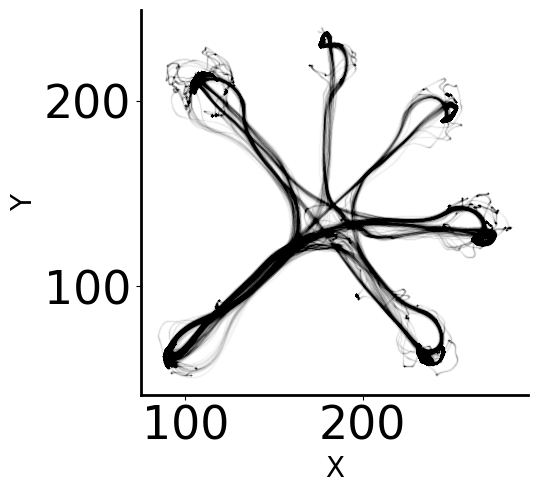

In [13]:
# Plot epoch's upsampled position to ensure we didnt mess something up
plt.figure(figsize=(5, 5))
plt.scatter(pos_up[:,0], pos_up[:,1], clip_on=False, s=1, color='black',alpha=0.002)
plt.xlabel('X')
plt.ylabel('Y')
sns.despine()

In [14]:
# If you are doing 1D decode, you need to do the liearization on the upsampled data, rather than upsampling the linear pos
# otherwise, the gaps in the lin pos on edges will get interp during upsampling
if DECODE_DIMS == 1:
    # Load track graph to obtain track graph, edges, and edge spacing for model
    tr_graph_file = os.path.join(paths['beh_path'], paths['nwb_file_stem']
                            + nwb_settings['fname_track_graph'])
    track_graph, edges, edge_spacing = tr_pre.get_track_map(file=os.path.join(tr_graph_file), plot=False)

    edge_order = edges # adjust if need different order
    
    linearized_df = get_linearized_position(pos_up, track_graph, edge_order=edge_order, edge_spacing=edge_spacing)
    pos_up = linearized_df['linear_position'].values
    
    segment_edges = []
    for curr_seg in np.unique(linearized_df['track_segment_id']):
        seg_pos = linearized_df.loc[linearized_df['track_segment_id'] == curr_seg,
                                'linear_position']
        segment_edges.append([np.nanmin(seg_pos),np.nanmax(seg_pos)])
    segment_edges = np.array(segment_edges)


In [15]:
# Get the index location of nans in the upsampled position data

if DECODE_DIMS == 1:
    nan_idx = np.where(np.isnan(pos_up))[0]
elif DECODE_DIMS == 2:
    nan_idx = np.where(np.isnan(pos_up[:,0]))[0]    

# Get the index location of vel_up of where the vel threshold is not met based on VEL_THRESH
if TRAIN == 'run':
    VEL_THRESH = 20 #tracking_settings['track_moving_threshold_cmPerSecs']
    still_idx = np.where(vel_up < VEL_THRESH)[0]

# Combine nan_idx and still_idx to get the index location of nans and stills
if TRAIN == 'run':
    train_idx = np.unique(np.concatenate((nan_idx, still_idx)))
elif TRAIN == 'all':
    train_idx = nan_idx

In [16]:
# Remove desired tracking data using train_idx
pos_train_up = np.delete(pos_up, train_idx, axis=0)
timestamps_train_up = np.delete(timestamps_up, train_idx, axis=0)

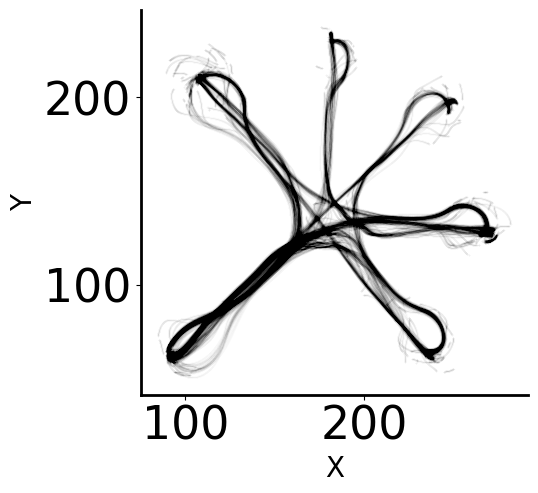

In [17]:
# Plot the pos data you will train on
if DECODE_DIMS == 1:
    plt.figure(figsize=(20, 5))
    plt.scatter(timestamps_train_up, pos_train_up, clip_on=False, s=1, color='black')
    plt.xlabel('Time')
    plt.ylabel('Linear Position')
    sns.despine()
elif DECODE_DIMS == 2:
    plt.figure(figsize=(5, 5))
    plt.scatter(pos_train_up[:,0], pos_train_up[:,1], clip_on=False, s=1, color='black',alpha=0.005)
    plt.xlabel('X')
    plt.ylabel('Y')
    sns.despine()

## Create spike data array for sorted spikes

Cols as unique neurons and rows as upsampled time

Bool array where a spike occuranced at that time is True and otherwise False

In [18]:
# Import spikes Data as df and TsGroup
nwb_units_df = day_rec.get_spikes() # import

# Convert to pynapple TsGroup
units_tsg = nap.TsGroup({i_unit: nap.Ts(this_unit)
     for i_unit, this_unit in 
     zip(nwb_units_df.index.values, nwb_units_df.spike_times)},
                time_support=epoch_train)
units_tsg.set_info(nwb_units_df.iloc[:, :-1])

In [19]:
units_CA1_tsg = {i_unit: nap.Ts(this_unit)
     for i_unit, this_unit in 
     zip(nwb_units_df.index.values, nwb_units_df.spike_times)
     if 'CA1' in nwb_units_df.loc[i_unit, 'region']}
units_PFC_tsg = {i_unit: nap.Ts(this_unit)
     for i_unit, this_unit in 
     zip(nwb_units_df.index.values, nwb_units_df.spike_times)
     if 'PFC' in nwb_units_df.loc[i_unit, 'region']}

# units_sorted_tsg = nap.TsGroup({**units_CA1_tsg, **units_PFC_tsg},
#                                time_support=epoch_train)
units_sorted_tsg = nap.TsGroup({**units_CA1_tsg},
                               time_support=epoch_train)
# units_sorted_tsg = nap.TsGroup({**units_PFC_tsg},
#                                time_support=epoch_train)

units_CA1_tsg = nap.TsGroup(units_CA1_tsg, time_support=epoch_train)
is_CA1 = pd.Series([False] * nwb_units_df.shape[0], name='is_CA1')
is_CA1[0:len(units_CA1_tsg)] = True
units_PFC_tsg = nap.TsGroup(units_PFC_tsg, time_support=epoch_train)
is_PFC = pd.Series([False] * nwb_units_df.shape[0], name='is_PFC')
is_PFC[0:len(units_PFC_tsg)] = True

In [20]:
# calc a histogram of spike times - returning the matrix of values
# and the bin centers
units_this_epoch = units_sorted_tsg.restrict(epoch_train)

spikes = dict()
for i_unit in units_this_epoch:
    spikes[i_unit] = np.histogram(units_this_epoch[i_unit].times(),
        bins=np.linspace(epoch_train.start[0], epoch_train.end[0], num=n_Bins))

# dict back into ndarray
spikes_up = np.array([spikes[i_unit][0] for i_unit in spikes]).T

# remove spikes during times that dont meet our training criteria
spikes_train_up = np.delete(spikes_up, train_idx, axis=0)

In [21]:

"""Classifies neural population representation of position and trajectory from clustered cells.

Parameters
----------
environments : list of Environment instances, optional
    The spatial environment(s) to fit
observation_models : ObservationModel instance, optional
    Links environments and encoding group
continuous_transition_types : list of list of transition matrix instances, optional
    Types of transition models, by default _DEFAULT_CONTINUOUS_TRANSITIONS
    Length correspond to number of discrete states.
discrete_transition_type : discrete transition instance, optional
initial_conditions_type : initial conditions instance, optional
    The initial conditions class instance
infer_track_interior : bool, optional
    Whether to infer the spatial geometry of track from position
sorted_spikes_algorithm : str, optional
    The type of algorithm. See _SORTED_SPIKES_ALGORITHMS for keys
sorted_spikes_algorithm_params : dict, optional
    Parameters for the algorithm.

"""

sampling_frequency = int(1 / BIN_SIZE)

# Model parameters 
# Parameters are directly from pose_analysis
continuous_transition_types = (
    [['random_walk', 'uniform'],
     ['uniform',     'uniform']])


classifier_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.5,
    'continuous_transition_types': continuous_transition_types,
    'discrete_transition_diag': 0.968,
    'knot_spacing': 8,
    'spike_model_penalty': 0.5,
}

if DECODE_DIMS == 1:
    environment = Environment(place_bin_size=5,
                          track_graph=track_graph,
                          edge_order=edge_order,
                          edge_spacing=edge_spacing)
    classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm='spiking_likelihood_kde',
    sorted_spikes_algorithm_params={'position_std': 6.0}
)
elif DECODE_DIMS == 2:
    environment = Environment(place_bin_size=5)
    classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    sorted_spikes_algorithm='spiking_likelihood_kde',
    sorted_spikes_algorithm_params={'position_std': 6.0}
)
    


classifier = SortedSpikesClassifier(environments=environment)



In [22]:

classifier.fit(position=pos_train_up,
                spikes=spikes_train_up);


c:\Users\BlakePorter\anaconda3\envs\SL_Analysis\Lib\site-packages\replay_trajectory_classification\continuous_state_transitions.py:24: RuntimeWarning: invalid value encountered in divide
  x /= x.sum(axis=1, keepdims=True)
c:\Users\BlakePorter\anaconda3\envs\SL_Analysis\Lib\site-packages\replay_trajectory_classification\likelihoods\spiking_likelihood_kde.py:117: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy))
c:\Users\BlakePorter\anaconda3\envs\SL_Analysis\Lib\site-packages\replay_trajectory_classification\likelihoods\spiking_likelihood_kde.py:117: RuntimeWarning: invalid value encountered in subtract
  return np.exp(np.log(mean_rate) + np.log(marginal_density) - np.log(occupancy))


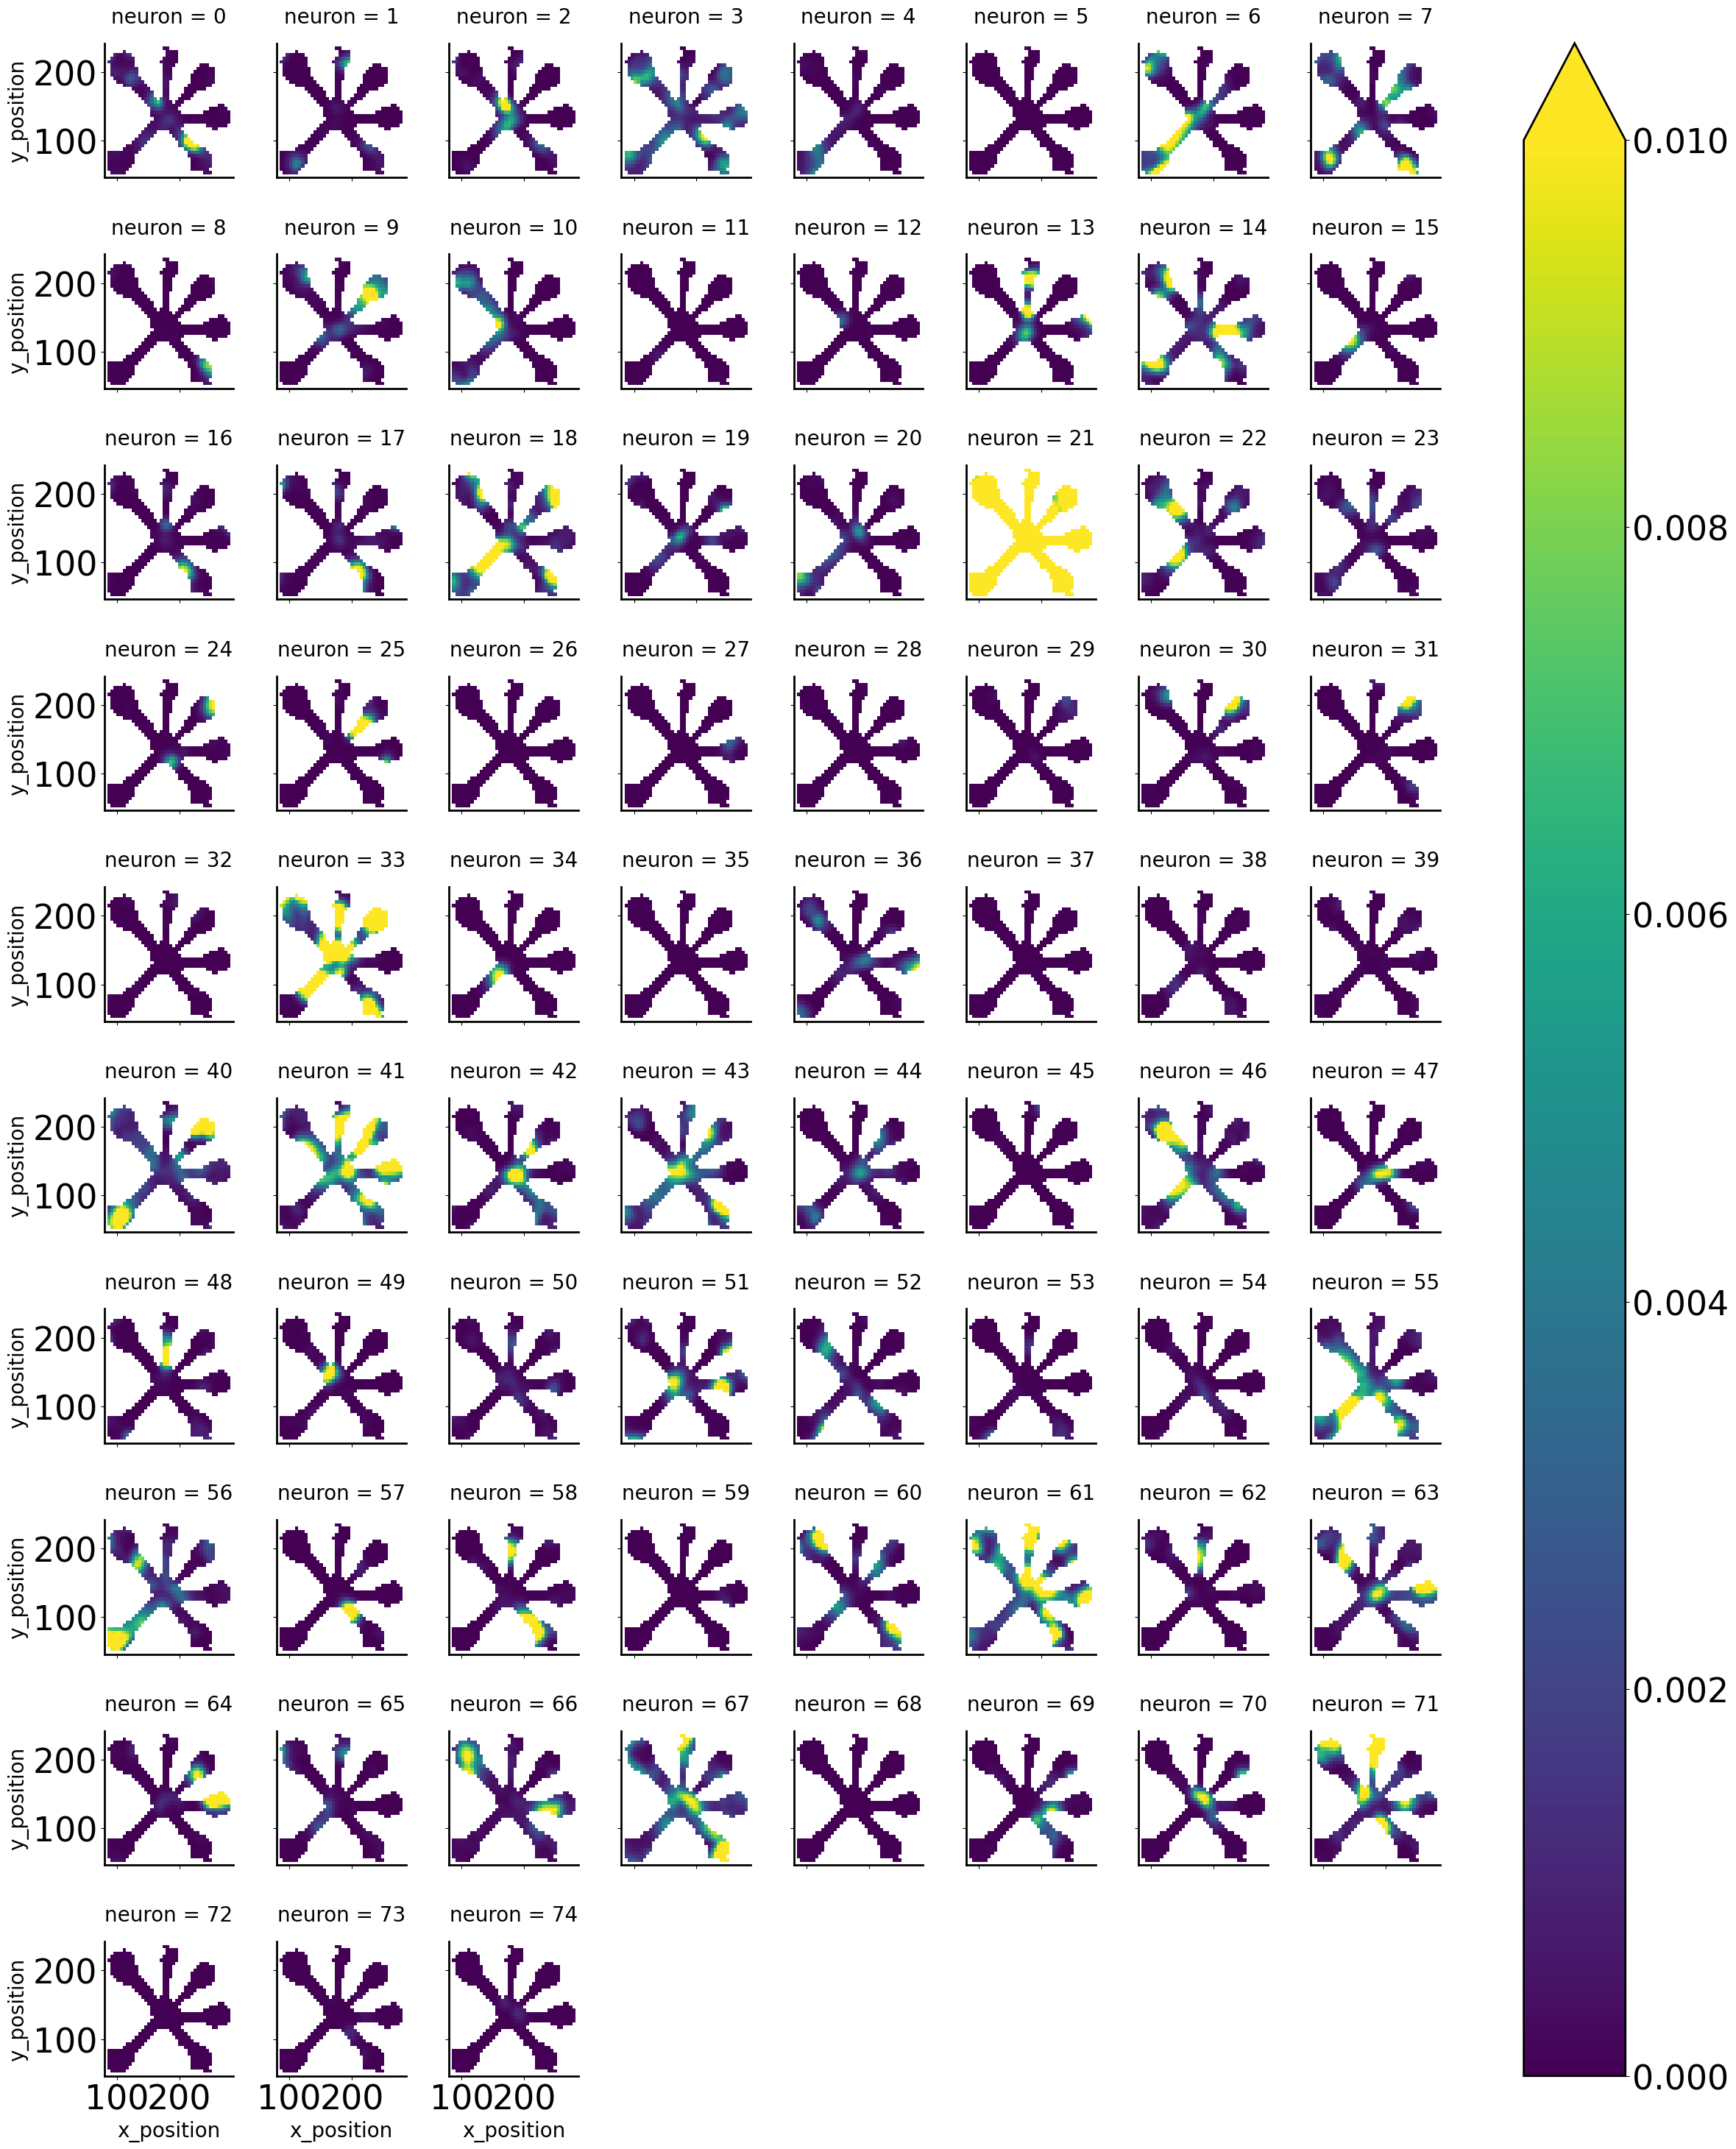

In [23]:

if DECODE_DIMS == 2:
    classifier.plot_place_fields()


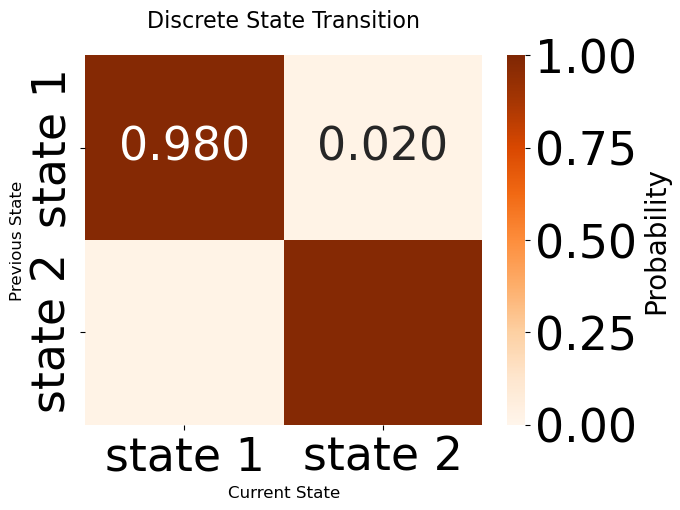

In [26]:
classifier.plot_discrete_state_transition() 

In [25]:

time_ind = slice(20_000, 25_000)
results = classifier.predict(spikes_up[time_ind], time=timestamps_up[time_ind])

  0%|          | 0/75 [00:00<?, ?it/s]

c:\Users\BlakePorter\anaconda3\envs\SL_Analysis\Lib\site-packages\replay_trajectory_classification\core.py:207: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  discrete_state_transition[state_k, state_k_1]


None of the decoder plotting works for the classifier since the classifier will give you multiple outputs depending on the state

TypeError: No numeric data to plot.

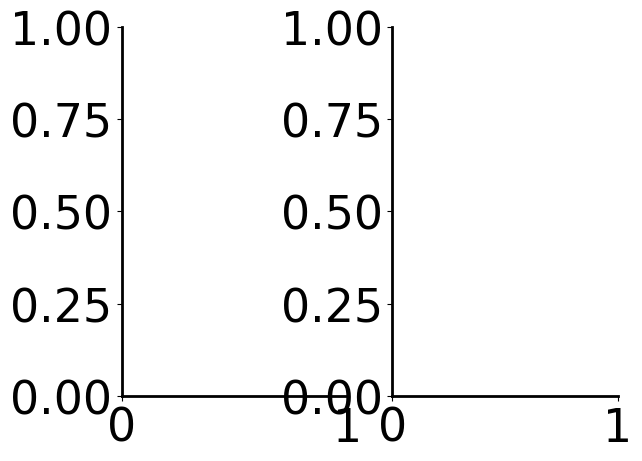

In [32]:
# classifier plotting


# plot_classifier_time_slice

posterior_type="acausal_posterior"

fig, axes = plt.subplots(
        1,
        1,
)

# trying to access data in results
# is track interior doesnt work here as an attr but it does seem to work in plot placefields, so something i being called wrong?
# idfk 

(results[posterior_type]
    .sum('state')
    .where(classifier.is_track_interior)
    .sel(time=time_ind)
    .plot(
    x="time", y="position", robust=True, ax=axes[0], vmin=0.0,
))

In [25]:

# MOVEMENT_VAR = 6.0

# if DECODE_DIMS == 1:
#     environment = Environment(place_bin_size=5,
#                           track_graph=track_graph,
#                           edge_order=edge_order,
#                           edge_spacing=edge_spacing)
# elif DECODE_DIMS == 2:
#     environment = Environment(place_bin_size=5)

# transition_type = RandomWalk(movement_var=MOVEMENT_VAR)

# going to try to just use the classifer, maybe will work better


# decoder = SortedSpikesDecoder(
#     environment=environment,
#     transition_type=transition_type,
#     sorted_spikes_algorithm='spiking_likelihood_glm', # glm for 2d
# )

# # kde for 1D
# decoder = SortedSpikesDecoder(
#     environment=environment,
#     transition_type=transition_type,
#     sorted_spikes_algorithm='spiking_likelihood_kde', # kde vs glm for 2d 1d ?
#     sorted_spikes_algorithm_params={'block_size': None,
#                                     'position_std': [6.0], # Eric said be cautious adjusting this, they tested and its good val for replays. 6 is default so this is a little pointless anyways
#                                     'use_diffusion': False},
# )

# sampling_frequency = int(1 / BIN_SIZE)


In [26]:
# a = decoder.place_fields_[:,54]
# b = decoder.environment.place_bin_edges_

# x_edges = np.unique(b[:,0]) # 43
# y_edges = np.unique(b[:,1]) # 41

# fields = np.reshape(a,(len(x_edges), len(y_edges)))

# trying to figure out the stripe fields
# see todo on pynaple decode too

In [27]:
# 1D transition matrix
if DECODE_DIMS == 1:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    edge1, edge2 = np.meshgrid(classifier.environment.place_bin_edges_, classifier.environment.place_bin_edges_)
    ax.pcolormesh(edge1, edge2, classifier.state_transition_.T, vmin=0.0, vmax=np.percentile(classifier.state_transition_, 99.9))
    ax.set_title("Random Walk State Transition Matrix")
    ax.set_ylabel("Position at time t-1")
    ax.set_xlabel("Position at time t")
    ax.axis("square")

In [28]:

# 1d place fields
if DECODE_DIMS == 1:
    fig, ax = plt.subplots(figsize=(10, 3))
    (classifier.place_fields_ * sampling_frequency).plot(x="position", hue="neuron", add_legend=False, ax=ax)
    ax.set_xlabel('Linear Position')
    ax.set_ylabel('Firing Rate')
    ax.set_xlim((0, np.nanmax(pos_up)))
    sns.despine()

In [29]:
# test hard code slice

time_ind = slice(50_000, 51_000)
results = classifier.predict(spikes_up[time_ind], time=timestamps_up[time_ind])

# 2D pm 1_000 samples takes 6.3 sec 10cm bins
# 2D on 10_000 samples takes 26.1 sec
# 2D on 20_000 samples takes 4min12 sec 2.5cm bins
# 2D on 550_000 samples takes 21 min on 5cm bins

  0%|          | 0/75 [00:00<?, ?it/s]

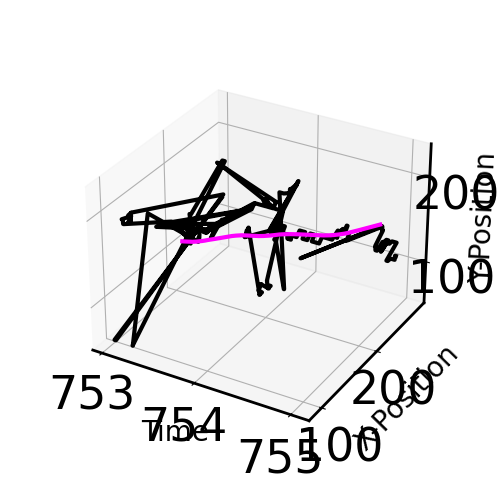

In [35]:
%matplotlib widget
# decoder 
if DECODE_DIMS == 2:
    # 2D data with 3D plot in time
    map_estimate = results.causal_posterior.stack(position=['x_position', 'y_position'])
    map_estimate = map_estimate.position[map_estimate.argmax('position')]
    map_estimate = np.asarray(map_estimate.values.tolist())

    plt.figure(figsize=(5, 5))
    ax = plt.axes(projection='3d')
    ax.plot3D(results.time, map_estimate[:, 0], map_estimate[:, 1], 'black', label='Most likely decoded position')
    #ax.scatter(results.time, map_estimate[:, 0], map_estimate[:, 1], 'black', label='Most likely decoded position')
    ax.set_xlabel('Time')
    ax.set_ylabel('X-Position')
    ax.set_zlabel('Y-Position')

    ax.plot3D(results.time, pos_up[time_ind, 0], pos_up[time_ind, 1], 'magenta', label='True position')
    ax.set_xlabel('Time')
    ax.set_ylabel('X-Position')
    ax.set_zlabel('Y-Position')
    #plt.legend()

TypeError: Axes.hist() got multiple values for argument 'x'

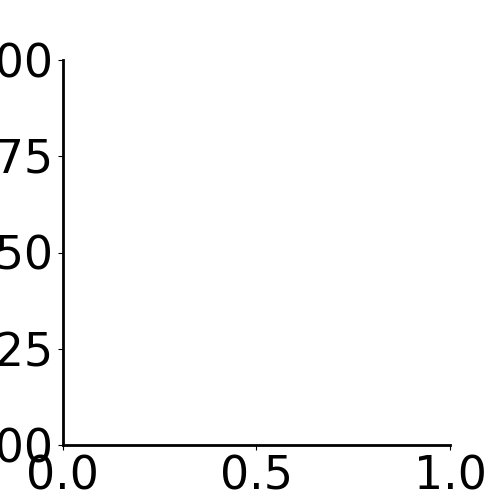

In [34]:
# 2D plots - works only decoder
if DECODE_DIMS == 2:
    plt.figure(figsize=(5, 5))

    results.acausal_posterior.sum('time').plot(x='x_position', y='y_position', cmap='bone_r')
    plt.scatter(pos_up[time_ind, 0], pos_up[time_ind, 1], color='magenta', s=1, clip_on=False, label='True Position')
    sns.despine()
    
# TODO
# i feel like the times are maybe off and the decode is a little ahead of the real in time?

In [ ]:
# 1D plot
time_ind = slice(50_000, 60_000)
results = classifier.predict(spikes_up[time_ind], time=timestamps_up[time_ind])

if DECODE_DIMS == 1:
        fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True, constrained_layout=True)

        spike_time_ind, neuron_ind = np.nonzero(spikes_up[time_ind])
        cmap = plt.get_cmap('tab20')
        c = [cmap.colors[ind % 20] for ind in neuron_ind]
        axes[0].scatter(timestamps_up[time_ind][spike_time_ind], neuron_ind, clip_on=False, s=1, c=c)
        axes[0].set_ylabel('Cells')

        for j in segment_edges[:,1]:
                axes[1].axhline(y = j, color = 'b', linestyle = '-',linewidth = 1) 
                
        results.causal_posterior.plot(x="time", y="position", ax=axes[1],
                                robust=True, cmap="bone_r", vmin=0.0, vmax=0.1,
                                clip_on=False)

        plt.scatter(timestamps_up[time_ind], pos_up[time_ind], color="red", s=0.5, clip_on=False, alpha=0.1)

        plt.set_ylabel('Linear Position')
        axes[1].set_xlabel('Time')
        sns.despine(offset=5)

In [ ]:
# okay let's recreate going through MUA events
# previously i binned at frame rate
MUA_BIN_SIZE = 0.05 # in seconds
SPK_SD_THRESHOLD = 3

# use pynapple's .getby_threshold() to remove interneurons that will just add noise to the thresholding 
units_this_epoch_pyr = units_this_epoch.getby_threshold('rate', 7, op = '<')

# bin spike counts
binned_spikes_all = units_this_epoch_pyr.count(bin_size=MUA_BIN_SIZE, time_units='s',ep=epoch_train)
epoch_binned_times = binned_spikes_all.times()
# mean across all units and convery to np.array
binned_spikes_mean = binned_spikes_all.mean(axis=1).as_array()

# put a boxcar filter on the binned spikes
# SMOOTHED CURRENTLY NOT USED
# smoothing can have a massive impact on the results and should be used with caution. you likely want to recalculate the threshold after smoothing
binned_spikes_smooth = sp.ndimage.filters.gaussian_filter1d(binned_spikes_mean, 1)

# Make one graph with two plots of 1000 elements with one plotting binned_spikes and the second plotting binned_spikes_smooth
spike_threshold = binned_spikes_mean.mean() + (binned_spikes_mean.std()*SPK_SD_THRESHOLD)
plt.figure(figsize=(20, 5))
time_ind = slice(5000, 10000)
plt.plot(binned_spikes_mean[time_ind], color='black')
plt.plot(binned_spikes_smooth[time_ind], color='red')
plt.plot(np.ones_like(binned_spikes_mean[time_ind]) * spike_threshold, color='blue')



In [72]:

# now with binned spiking activity, i want to find the indecies when the spike count goes over a certain threshold and then use that as the time of the events
# I will use a threshold based on the mean and std of the binned spikes
spike_threshold = binned_spikes_mean.mean() + (binned_spikes_mean.std()*SPK_SD_THRESHOLD)
MUA_events = np.where(binned_spikes_mean >= spike_threshold)
MUA_event_times = epoch_binned_times[MUA_events]

MUA_BIN_CONCAT = 0.1 # in seconds

# MUA_event_times has times of events
# however, some of these events may be close together
# i want to go through MUA_event_times and treat them as the start time of an event
# the end time of an event will be MUA_BIN_SIZE seconds later 
# however, i want to concatenate events that occur within MUA_BIN_CONCAT of each other so that the end time is extended
# i will then use the start and end times to create a new epoch

MUA_event_diff = np.diff(MUA_event_times)
MUA_event_diff = np.insert(MUA_event_diff, 0, [0])
MUA_event_diff_bool = MUA_event_diff <= MUA_BIN_CONCAT

MUA_event_start_times = [MUA_event_times[0]]
MUA_event_end_times = []

# create a list of start and end times
for curr_pos in range(len(MUA_event_diff_bool)-1):
    if MUA_event_diff_bool[curr_pos] == False:
        MUA_event_start_times.append(MUA_event_times[curr_pos])
    if MUA_event_diff_bool[curr_pos] == True and MUA_event_diff_bool[curr_pos+1] == False:
        MUA_event_end_times.append(MUA_event_times[curr_pos])
    if MUA_event_diff_bool[curr_pos] == False and MUA_event_diff_bool[curr_pos+1] == False:
        MUA_event_end_times.append(MUA_event_times[curr_pos])
        
if MUA_event_diff_bool[-1] == True:
    MUA_event_end_times.append(MUA_event_times[-1])

# If the different between the start_times and end_times are 0, so 1 bin of high MUA, add MUA_BIN_SIZE to the end time to make it a duration the size of our bin
for i, (start, end) in enumerate(zip(MUA_event_start_times, MUA_event_end_times)):
    if end - start == 0:
        MUA_event_end_times[i] = start + MUA_BIN_SIZE

# make a data frame combining MUA_event_times, MUA_event_diff, MUA_event_diff_bool
#MUA_event_df = pd.DataFrame({'event_times': MUA_event_times, 'event_diff': MUA_event_diff, 'event_diff_bool': MUA_event_diff_bool})

#MUA_event_epochs_df = pd.DataFrame({'start_times': MUA_event_start_times, 'end_times': MUA_event_end_times, 'duration': np.array(MUA_event_end_times) - np.array(MUA_event_start_times)})

In [73]:
# Now we have MUA_event_start_times and MUA_event_end_times where spike counts are above threshold
# Now we need to check the velocity of the animal during these epochs and only keep the times where the animal is not moving
# traf_df_epoch already has the velocity of the animal in vel col
# however, event_start and event_end times are binned and not the same values as the trag_df_train index, so find the closet index in traf_df_epoch to the event_start and event_end times
# then check the velocity of the animal at those times
# if the velocity is below a certain threshold, keep the event, if not, discard it

VEL_THRESH = tracking_settings['track_moving_threshold_cmPerSecs']
MUA_event_vel = []
MUA_event_start_times_good = []
MUA_event_end_times_good = []

for start, end in zip(MUA_event_start_times, MUA_event_end_times):
    start_ind = np.abs(traf_df_epoch.index - start).argmin()
    end_ind = np.abs(traf_df_epoch.index - end).argmin()
    if traf_df_epoch['vel'].iloc[start_ind:end_ind].mean() < VEL_THRESH:
        MUA_event_start_times_good.append(start)
        MUA_event_end_times_good.append(end)
        MUA_event_vel.append(traf_df_epoch['vel'].iloc[start_ind:end_ind].mean())
        

# create a pandas dataframe with the start and end times of the MUA events as well as event_vel and duration
MUA_event_epochs_df = pd.DataFrame({'start_times': MUA_event_start_times_good, 'end_times': MUA_event_end_times_good, 'duration': np.array(MUA_event_end_times_good) - np.array(MUA_event_start_times_good), 'vel': MUA_event_vel})


In [ ]:
# Parse MUA events again based on spike times so that they start on the first spike time and end on the last spike time
# this should help tighten Eric's decoder
MUA_event_spike_start_times = []
MUA_event_spike_end_times = []

# initialize a boolean list to keep track of which events are good
MUA_event_good = [False] * len(MUA_event_start_times_good)

# use MUA_event_epochs_df and go through each row in start_times and end_times and find the closest spike time to the start and end times using spike_times_all_list
# then create a new dataframe of the start and end times of the MUA events based on the spike times
for start, end in zip(MUA_event_start_times_good, MUA_event_end_times_good):
    # create an nap.IntervalSet with the start and end times
    event_interval = nap.IntervalSet(start, end)
    # restrict the spike times to the event_interval
    event_spike_times = units_this_epoch_pyr.restrict(event_interval).to_tsd().times()
    
    # if event_spike_times is empty, then the event is not good
    if len(event_spike_times) == 0:
        continue
    else:
        MUA_event_spike_start_times.append(event_spike_times[0])
        MUA_event_spike_end_times.append(event_spike_times[-1])
        MUA_event_good # set to true i dont know how to index
        


In [ ]:
# replace start_times and end_times in MUA_event_epochs_df with MUA_event_spike_start_times and MUA_event_spike_end_times
MUA_event_epochs_df['start_times'] = MUA_event_spike_start_times
MUA_event_epochs_df['end_times'] = MUA_event_spike_end_times
    

In [ ]:
# Use the start times from MUA_event_epochs_df to index to the x and y positions of the animal in the traf_df_epoch
start_ind = [np.abs(traf_df_epoch.index - start).argmin() for start in MUA_event_epochs_df['start_times']]

MUA_event_epochs_df['x_start'] = traf_df_epoch['x'].iloc[start_ind].values
MUA_event_epochs_df['y_start'] = traf_df_epoch['y'].iloc[start_ind].values

# now use the x_start and y_start to plot every event on the track overlaid by the animal's x and y position from traf_df_epoch
plt.figure(figsize=(12, 10))
plt.scatter(traf_df_epoch['x'],traf_df_epoch['y'],s=1,color='black',alpha=0.1)
plt.scatter(MUA_event_epochs_df['x_start'], MUA_event_epochs_df['y_start'], color='red', s=10)
plt.title('MUA events on track')

# Okay these look to be working and mainly getting events at reward wells

In [ ]:

# Now we can loop through MUA_event_epochs_df and create time slices around each event using start_times and end_times
# we can use these time slices to run the decoder on each event 

if DECODE_DIMS == 1:
    offset = 0.05 # additional time around epoch to show

    for i in range(len(MUA_event_epochs_df)):
        time_ind = slice(np.abs(timestamps_up - (MUA_event_epochs_df['start_times'].iloc[i]-offset)).argmin(), np.abs(timestamps_up - (MUA_event_epochs_df['end_times'].iloc[i]+offset)).argmin())
        
        if time_ind.start == time_ind.stop:
            print('Start and stop of MUA is the same time')
            continue
        else:
            results = classifier.predict(spikes_up[time_ind], time=timestamps_up[time_ind])
            
            spike_ind, neuron_ind = np.nonzero(spikes_up[time_ind])
            time_now = timestamps_up[time_ind]
            
            fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8, 16))
            c = [0.4660, 0.6740, 0.1880]
            axes[0].scatter(time_now[spike_ind], neuron_ind+1, color=c, s=30, clip_on=False)
            axes[0].set_yticks([])
            #axes[0].set_yticks((1, spikes_track.shape[1]))
            #axes[0].set_ylabel('Cells')
            
            for j in segment_edges[:,1]:
                axes[1].axhline(y = j, color = 'b', linestyle = '-',linewidth = 1) 
                
            axes[1].plot(timestamps_up[time_ind], pos_up[time_ind], color="red", linestyle="-", linewidth=3, clip_on=False,alpha=0.6)
            results.acausal_posterior.plot(x="time", y="position", ax=axes[1], cmap="bone_r", vmin=0.0, clip_on=False)  # vmax=0.5

            sns.despine(offset=5)
            axes[1].spines['top'].set_visible(False)
            axes[1].spines['right'].set_visible(False)
            #axes[1].set_xticks([])
            axes[1].set_yticks([])
            axes[1].set_ylabel('')
            axes[1].set_xlabel('')
            axes[1].set_title(f"Event {i+1}")
            plt.savefig(os.path.join(paths["figure_path"], f"CA1_acaus_MUA_event_{i+1}.png"))
            plt.close()
            

In [ ]:
# 2D MUA event replay events
# Same as above but in 2D
# loops through MUA events and plots the summed posteriors for that time

if DECODE_DIMS == 2:
    offset = 0.02 # additional time around epoch to show
    for i in range(len(MUA_event_epochs_df)):
        time_ind = slice(np.abs(timestamps_up - (MUA_event_epochs_df['start_times'].iloc[i]-offset)).argmin(), np.abs(timestamps_up - (MUA_event_epochs_df['end_times'].iloc[i]+offset)).argmin())
        
        if time_ind.start == time_ind.stop:
            print('Start and stop of MUA is the same time')
            continue
        else:
            results = classifier.predict(spikes_up[time_ind], time=timestamps_up[time_ind])
            
            plt.figure(figsize=(5, 5))

            results.acausal_posterior.sum('time').plot(x='x_position', y='y_position', cmap='bone_r')
            plt.scatter(pos_up[time_ind, 0], pos_up[time_ind, 1], color='magenta', s=1, clip_on=False, label='True Position')

            plt.savefig(os.path.join(paths["figure_path"], f"CA1_2D_acaus_MUA_event_{i+1}.png"))
            plt.close()
    

In [ ]:
# 1D
# Careful another loop figure
# I want to go through every trial (home to home) and plot the raster and deocde

# go through visits_df and get only rows that contain a 1 in the 'id' column
# these are the trials that are home to home
# then go through each row and get the start and end time of the trial
# use these times to slice the data and run the decoder on each slice

# 117 huge

if DECODE_DIMS == 1:
        visits_home_df = visits_df[visits_df['id'] == '1'] # wtf id is a string not an int
        start_times = visits_home_df['start_time'].values
        
        for curr_trial in range(len(start_times)-1):
                
                start_time = start_times[curr_trial]
                end_time = start_times[curr_trial+1]
                
                time_ind = slice(np.abs(timestamps_up - start_time).argmin(), np.abs(timestamps_up - end_time).argmin())
                
                results = classifier.predict(spikes_up[time_ind], time=timestamps_up[time_ind])
                
                spike_time_ind, neuron_ind = np.nonzero(spikes_up[time_ind])
                time_now = timestamps_up[time_ind]
                
                fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8, 8))
                cmap = plt.get_cmap('tab20')
                c = [cmap.colors[ind % 20] for ind in neuron_ind]
                axes[0].scatter(timestamps_up[time_ind][spike_time_ind], neuron_ind, clip_on=False, s=1, c=c)
                axes[0].set_ylabel('Cells')
                
                for j in segment_edges[:,1]:
                        axes[1].axhline(y = j, color = 'b', linestyle = '-',linewidth = 1) 
                        
                axes[1].plot(timestamps_up[time_ind], pos_up[time_ind], color="red", linestyle="-", linewidth=3, clip_on=False,alpha=0.2)
                results.acausal_posterior.plot(x="time", y="position", ax=axes[1], cmap="bone_r", vmin=0.0, vmax=0.2, clip_on=False)
                plt.savefig(os.path.join(paths["figure_path"], f"CA1_trial_{curr_trial}.png"))
                plt.close()

In [ ]:
results

In [ ]:
# Break out all results data for debugging
# coordinates
r_time = results.time.to_numpy()
r_x = results.x_position.to_numpy()
r_y = results.y_position.to_numpy()

# diff r_x
a = np.diff(r_y)

r_acaus = results.acausal_posterior.to_numpy()
r_cause = results.causal_posterior.to_numpy()
r_like = results.likelihood.to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(r_acaus[0,:,:], aspect='auto', cmap='bone_r')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(r_cause[0,:,:], aspect='auto', cmap='bone_r')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(r_like[0,:,:], aspect='auto', cmap='bone_r')


In [ ]:

# Get out the posterior of interest and time (time should be same as timestamps_up)
results_posterior = results.acausal_posterior.to_numpy() # this will be N time bins long (rows) and M spatial bins wide (col)


# this does not work for 2D because results_posterior will be a 3D array
# results_posterior = pd.DataFrame(results_posterior, index=timestamps_up)

play = results_posterior[0,:,:]

plt.imshow(play, cmap='bone_r', aspect='auto')
plt.colorbar()

# Now use start_time and end_time to find the closest index value of results_posterior, grab those data as results_posterior_epoch
# start_time = 1000
# end_time = 1200

# start_ind = np.abs(results_posterior.index - start_time).argmin()
# end_ind = np.abs(results_posterior.index - end_time).argmin()
# results_posterior_epoch = results_posterior.iloc[start_ind:end_ind+1]

# Idk this works but at this point i dont want to do all the graphing code
